In [1]:
#导入相关函数库
import os
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm
import re
from scipy.stats.mstats import winsorize
from scipy.stats import ttest_1samp
import statsmodels.api as sm
from sklearn.preprocessing import MinMaxScaler 
import pandas as pd
pd.set_option('display.max_colwidth', None)
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import matplotlib
import matplotlib.colors as mcolors
from matplotlib.font_manager import FontProperties
plt.rcParams['font.sans-serif'] = ['SimHei']  # 设置中文字体为黑体
plt.rcParams['axes.unicode_minus'] = False  # 解决负号无法显示的问题
from sklearn.preprocessing import StandardScaler
pd.set_option('display.max_columns', 80)
from pandas.tseries.offsets import DateOffset


## Step1：Data Processing
导入雪球平台讨论和2010年11月至2023年10月的公司公告的月度情感均值，导入对应日期的股票回报率和无风险利率。  
依照月份与股票代码进行合并，得到2010年11月至2023年10月的情感分歧以及2010年11月至2023年11月股票的超额收益率。
对数据进行描述性统计

In [2]:
post_emo = pd.read_excel(r'E:\雪球发帖情感按月聚合\全部月度雪球情感.xlsx')
display(post_emo)
#post_emo = pd.read_excel(r"E:\月度雪球情感(all).xlsx")

post_emo['Stkcd']=post_emo['Stkcd'].astype(str).str.zfill(6)
display(post_emo)

announce_emo = pd.read_excel(r"E:\公司情感按月聚合总.xlsx")
announce_emo['Stkcd']=announce_emo['Stkcd'].astype(str).str.zfill(6)
display(announce_emo)

stk_r = pd.read_csv(r"E:\股票月回报率.csv")
stk_r['Stkcd']=stk_r['Stkcd'].astype(str).str.zfill(6)
stk_r.rename(columns={'Trdmnt': 'month'}, inplace=True)

Nrrate = pd.read_excel(r"E:\月度平均无风险利率.xlsx")
display(stk_r)
display(Nrrate)

,Stkcd,month,post_emo
0,2,2010-11,0.000000
1,2,2010-12,0.000000
2,2,2011-01,0.000000
3,2,2011-02,0.000000
4,2,2011-03,0.000000
...,...,...,...
778903,873593,2023-06,0.023266
778904,873593,2023-07,0.024569
778905,873593,2023-08,0.019093
778906,873593,2023-09,0.030480


,Stkcd,month,post_emo
0,000002,2010-11,0.000000
1,000002,2010-12,0.000000
2,000002,2011-01,0.000000
3,000002,2011-02,0.000000
4,000002,2011-03,0.000000
...,...,...,...
778903,873593,2023-06,0.023266
778904,873593,2023-07,0.024569
778905,873593,2023-08,0.019093
778906,873593,2023-09,0.030480


,Stkcd,month,announce_emo
0,000002,2011-06,0.014132
1,000006,2010-11,0.004136
2,000006,2010-12,0.001847
3,000006,2011-01,0.007076
4,000006,2011-03,0.017079
...,...,...,...
416749,873593,2023-05,0.011982
416750,873593,2023-06,0.013842
416751,873593,2023-08,0.011700
416752,873593,2023-09,0.018387


,Stkcd,month,Mclsprc,Msmvosd,Mretwd
0,000002,2009-06,12.75,1.197492e+08,0.314909
1,000002,2009-07,13.36,1.254784e+08,0.047843
2,000002,2009-08,9.40,8.828569e+07,-0.296407
3,000002,2009-09,10.42,9.786563e+07,0.108511
4,000002,2009-10,11.51,1.081030e+08,0.104607
...,...,...,...,...,...
505376,873693,2023-10,34.55,4.177786e+05,NaN
505377,873693,2023-11,49.96,6.041163e+05,0.446020
505378,873726,2023-10,21.80,4.533911e+05,NaN
505379,873726,2023-11,29.15,5.084173e+05,0.337156


,month,月度化无风险利率(%)
0,2010-11,0.206000
1,2010-12,0.209929
2,2011-01,0.226300
3,2011-02,0.240800
4,2011-03,0.246600
...,...,...
152,2023-07,0.124100
153,2023-08,0.124100
154,2023-09,0.124100
155,2023-10,0.124100


### 情感指标，超额收益率导入

In [3]:
divergence = pd.merge(post_emo, announce_emo, on = ['Stkcd','month'])
divergence = divergence.drop_duplicates()
divergence['emo_dv'] = divergence['post_emo'] - divergence['announce_emo']

# 归一化
divergence['emo_dv'] = ((divergence['post_emo'] - divergence['post_emo'].mean()) / divergence['post_emo'].std()) - \
                             ((divergence['announce_emo'] - divergence['announce_emo'].mean()) / divergence['announce_emo'].std())

divergence = pd.merge(divergence, stk_r, on = ['Stkcd','month'], how='right') 
divergence = pd.concat([divergence[divergence['month'] != '2023-11'].dropna(),divergence[divergence['month'] == '2023-11']])


divergence = pd.merge(divergence, Nrrate, on = 'month')
divergence = divergence.sort_values(by=['Stkcd','month'])
divergence['excess return'] = divergence['Mretwd'] - divergence['月度化无风险利率(%)']/100
divergence = divergence.reset_index(drop=True)
display(divergence)
display(divergence.describe())
divergence['excess return'] = divergence.groupby(['Stkcd'])['excess return'].shift(-1)

divergence['month'] = pd.to_datetime(divergence['month'], format='%Y-%m')
divergence['year'] = divergence['month'].dt.year
divergence['sft_year'] = (divergence['month'] - DateOffset(months=6)).dt.year


,Stkcd,month,post_emo,announce_emo,emo_dv,Mclsprc,Msmvosd,Mretwd,月度化无风险利率(%),excess return
0,000002,2011-06,-0.000665,0.014132,-0.849500,8.45,8.161499e+07,0.077806,0.2669,0.075137
1,000002,2013-01,0.009261,0.010301,0.372211,12.01,1.160430e+08,0.186759,0.2466,0.184293
2,000002,2014-05,0.006244,0.030562,-2.290318,8.55,8.273138e+07,0.142649,0.2466,0.140183
3,000002,2014-06,0.006960,0.008348,0.429874,8.27,7.998672e+07,-0.032749,0.2466,-0.035215
4,000002,2014-07,0.008438,0.023912,-1.324055,9.90,9.575194e+07,0.197098,0.2466,0.194632
...,...,...,...,...,...,...,...,...,...,...
401279,873665,2023-11,NaN,NaN,NaN,8.92,2.942994e+05,0.567663,0.1241,0.566422
401280,873679,2023-11,NaN,NaN,NaN,23.00,2.938940e+05,NaN,0.1241,NaN
401281,873693,2023-11,NaN,NaN,NaN,49.96,6.041163e+05,0.446020,0.1241,0.444779
401282,873726,2023-11,NaN,NaN,NaN,29.15,5.084173e+05,0.337156,0.1241,0.335915


,post_emo,announce_emo,emo_dv,Mclsprc,Msmvosd,Mretwd,月度化无风险利率(%),excess return
count,396247.000000,396247.000000,396247.000000,401284.000000,4.012840e+05,401267.000000,401284.000000,401267.000000
mean,0.011446,0.014724,0.009291,19.676772,9.935748e+06,0.010046,0.154222,0.008503
std,0.012962,0.008390,1.323355,35.158533,3.667393e+07,0.146313,0.054171,0.146297
min,-0.142857,-0.081695,-14.502185,0.120000,5.542006e+04,-0.863517,0.124100,-0.864758
25%,0.000000,0.009393,-0.779751,7.080000,2.045098e+06,-0.071226,0.124100,-0.072724
50%,0.010830,0.014200,0.009375,12.160000,3.930554e+06,-0.003416,0.124100,-0.004931
75%,0.018937,0.019420,0.806695,21.540000,8.310784e+06,0.071429,0.144700,0.069911
max,0.190476,0.140371,14.727782,2218.000000,2.786247e+09,5.116070,0.287100,5.114829


### 财务指标导入

“市值” (Size) 指标是以股票 i在第 t 年 6月底的流通市值；
“账面市值比”(BM)是用第t-1年末的“账面价值/股票i的流通市值”；
“资产收益率”(OP)是用第t-1年末的“资产收益率”；
“资产增长率”(AG)是用第t-1年末相对于第t-2年末的总资产增加额，除以第t-2年末的总资产。

In [4]:
feature_df = pd.read_csv(r"E:\财务指标文件\CSR_Finidx.csv")
feature_df['Stkcd']=feature_df['Stkcd'].astype(str).str.zfill(6)
feature_df['Accper']=pd.to_datetime(feature_df['Accper'])
display(feature_df)

,Stkcd,Accper,A100000,A200000,A300000,B150101,T40401,T40402,T40403,T40801,T40802,T40803,T60200,T40902,Outcap
0,000002,2008-12-31,1.192366e+11,8.041803e+10,3.189193e+10,4.639869e+09,0.038913,0.042309,0.042309,0.126464,0.131866,0.131866,0.421990,0.151396,2.152837e+08
1,000002,2009-12-31,1.376086e+11,9.220004e+10,3.737589e+10,6.430008e+09,0.046727,0.050069,0.050069,0.142598,0.153888,0.153888,0.584801,0.193966,8.060622e+08
2,000002,2010-12-31,2.156376e+11,1.610514e+11,4.423268e+10,8.839611e+09,0.040993,0.050048,0.050048,0.164655,0.178489,0.178489,0.803951,0.037342,2.619386e+08
3,000002,2011-12-31,2.962084e+11,2.283759e+11,5.296780e+10,1.159961e+10,0.039160,0.045325,0.045325,0.181712,0.198042,0.198042,1.054969,0.411367,2.615609e+08
4,000002,2012-12-31,3.788016e+11,2.966634e+11,6.382555e+10,1.566259e+10,0.041348,0.046407,0.046407,0.196648,0.214930,0.214930,1.424448,0.438351,1.506676e+08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49049,873806,2021-12-31,5.124748e+09,4.135552e+09,9.066493e+08,1.221275e+08,0.023831,0.022725,NaN,0.121368,0.129208,NaN,NaN,NaN,2.139889e+07
49050,873806,2022-12-31,3.780017e+09,2.829279e+09,9.462263e+08,1.023510e+08,0.027077,0.022988,0.022988,0.104192,0.106417,0.106417,NaN,NaN,4.870094e+07
49051,873806,2023-12-31,3.210519e+09,2.144021e+09,1.061128e+09,1.157604e+08,0.036057,0.033119,0.033119,0.108283,0.114481,0.114481,NaN,NaN,5.940754e+07
49052,873833,2022-12-31,7.068130e+08,2.272433e+08,4.777225e+08,5.065831e+07,0.071671,0.071819,NaN,0.107403,0.110842,NaN,NaN,NaN,3.961650e+07


#### 市值计算

In [5]:
# 创建一个新的 DataFrame 存储指定条件下的信息
indicators = pd.DataFrame()
stk_r['month'] = pd.to_datetime(stk_r['month']).dt.to_period("M")
# 提取 'Trdmnt' 列的年份和月份
stk_r['Year'] = stk_r['month'].dt.year
stk_r['mon_id'] = stk_r['month'].dt.month

# 筛选条件：股票 i 在第 t 年 6 月底
condition = (stk_r['mon_id'] == 6)

# 将符合条件的数据存储到新的 DataFrame 中
indicators['Stkcd'] = stk_r.loc[condition, 'Stkcd']
indicators['Period'] = stk_r.loc[condition, 'Year']
indicators['Size'] = stk_r.loc[condition, 'Msmvosd']*1000

# 打印新的 DataFrame
display(indicators)

,Stkcd,Period,Size
0,000002,2009,1.197492e+11
12,000002,2010,6.546822e+10
24,000002,2011,8.161499e+10
36,000002,2012,8.608689e+10
48,000002,2013,9.517262e+10
...,...,...,...
505313,873223,2023,2.388880e+08
505325,873305,2023,1.119294e+08
505338,873339,2023,2.585521e+08
505352,873527,2023,1.728361e+08


#### 账面市值比计算

In [6]:
#获取年末账面价值
BM_book_value = feature_df[['Stkcd','Accper','A300000']]
BM_book_value['Accper'] = pd.to_datetime(BM_book_value['Accper']).dt.to_period("M")
BM_book_value = BM_book_value[BM_book_value['Accper'].dt.month == 12]

#获取年末流通市值
BM_merged_market_data=stk_r[['Stkcd','month','Msmvosd']]
BM_merged_market_data = BM_merged_market_data[BM_merged_market_data['month'].dt.month == 12]
BM_book_value = BM_book_value.rename(columns={'Accper': 'month'})

BM_book_value = pd.merge(BM_book_value,BM_merged_market_data , on=['Stkcd','month'])
#年末账面价值/年末流通市值
BM_book_value['BM'] = BM_book_value['A300000']/(BM_book_value['Msmvosd']*1000)#单位换算
BM_book_value['Period'] = BM_book_value['month'].dt.year+1

indicators = pd.merge(BM_book_value[['Stkcd','BM','Period']],indicators, on = ['Period','Stkcd'])
display(indicators)

,Stkcd,BM,Period,Size
0,000002,0.358067,2010,6.546822e+10
1,000002,0.556999,2011,8.161499e+10
2,000002,0.734139,2012,8.608689e+10
3,000002,0.652748,2013,9.517262e+10
4,000002,0.989655,2014,7.998672e+10
...,...,...,...,...
39062,873169,1.856448,2023,2.590794e+08
39063,873223,2.088306,2023,2.388880e+08
39064,873305,2.777609,2023,1.119294e+08
39065,873339,1.886143,2023,2.585521e+08


#### 资产收益率计算

In [7]:
# 提取 'Trdmnt' 列的年份和月份
feature_df['Year'] = feature_df['Accper'].dt.year
feature_df['mon_id'] = feature_df['Accper'].dt.month

# 筛选条件：股票 i 在第 t-1 年 年底
condition = (feature_df['mon_id'] == 12)

ROA = feature_df[['Stkcd','Accper','T40402']]
# 将符合条件的数据存储到新的 DataFrame 中
ROA['ROA'] = feature_df.loc[condition, 'T40402']
ROA['Period'] = ROA['Accper'].dt.year+1

indicators = pd.merge(ROA[['Stkcd','ROA','Period']],indicators, on = ['Period','Stkcd'])
display(indicators)

,Stkcd,ROA,Period,BM,Size
0,000002,0.050069,2010,0.358067,6.546822e+10
1,000002,0.050048,2011,0.556999,8.161499e+10
2,000002,0.045325,2012,0.734139,8.608689e+10
3,000002,0.046407,2013,0.652748,9.517262e+10
4,000002,0.042651,2014,0.989655,7.998672e+10
...,...,...,...,...,...
39062,873169,0.130725,2023,1.856448,2.590794e+08
39063,873223,0.020088,2023,2.088306,2.388880e+08
39064,873305,0.072405,2023,2.777609,1.119294e+08
39065,873339,0.208046,2023,1.886143,2.585521e+08


#### 资产增长率计算

In [8]:
AG_merged_financial_data = feature_df[['Stkcd','Accper','A100000']]
AG_merged_financial_data = AG_merged_financial_data[AG_merged_financial_data['Accper'].dt.month == 12]

# 根据 'Stkcd' 列进行分组，并计算 'A100000' 列的总资产增加额
AG_merged_financial_data['AssetIncrease'] = AG_merged_financial_data.groupby('Stkcd')['A100000'].diff()

# 计算投资风格（AG），用第 t-1 年末相对于第 t-2 年末的总资产增加额，除以第 t-2 年末的总资产
AG_merged_financial_data['AG'] = AG_merged_financial_data['AssetIncrease'] / AG_merged_financial_data['A100000'].shift(1)

# 将对于没有 t-1, t-2 年的年份的 AG 存为 Na
AG_merged_financial_data.loc[AG_merged_financial_data['Accper'].dt.year < 2009, 'AG'] = float('nan')
AG_merged_financial_data['Period'] = AG_merged_financial_data['Accper'].dt.year + 1

indicators = pd.merge(AG_merged_financial_data[['Stkcd','AG','Period']],indicators, on = ['Period','Stkcd'])
# 打印 DataFrame
display(indicators)


,Stkcd,AG,Period,ROA,BM,Size
0,000002,0.154080,2010,0.050069,0.358067,6.546822e+10
1,000002,0.567036,2011,0.050048,0.556999,8.161499e+10
2,000002,0.373640,2012,0.045325,0.734139,8.608689e+10
3,000002,0.278835,2013,0.046407,0.652748,9.517262e+10
4,000002,0.265056,2014,0.042651,0.989655,7.998672e+10
...,...,...,...,...,...,...
39062,873169,0.786868,2023,0.130725,1.856448,2.590794e+08
39063,873223,0.309129,2023,0.020088,2.088306,2.388880e+08
39064,873305,0.701587,2023,0.072405,2.777609,1.119294e+08
39065,873339,0.330094,2023,0.208046,1.886143,2.585521e+08


#### 相对资本支出计算

In [9]:
#获取年末资本支出
RCA = feature_df[['Stkcd','Accper','Outcap','A100000']]
RCA['Accper'] = pd.to_datetime(RCA['Accper']).dt.to_period("M")
RCA['RCA']=RCA['Outcap'] / RCA['A100000']
RCA['Period'] = RCA['Accper'].dt.year + 1
display(RCA)

indicators = pd.merge(RCA[['Stkcd','RCA','Period']],indicators, on = ['Period','Stkcd'])
display(indicators)

,Stkcd,Accper,Outcap,A100000,RCA,Period
0,000002,2008-12,2.152837e+08,1.192366e+11,0.001806,2009
1,000002,2009-12,8.060622e+08,1.376086e+11,0.005858,2010
2,000002,2010-12,2.619386e+08,2.156376e+11,0.001215,2011
3,000002,2011-12,2.615609e+08,2.962084e+11,0.000883,2012
4,000002,2012-12,1.506676e+08,3.788016e+11,0.000398,2013
...,...,...,...,...,...,...
49049,873806,2021-12,2.139889e+07,5.124748e+09,0.004176,2022
49050,873806,2022-12,4.870094e+07,3.780017e+09,0.012884,2023
49051,873806,2023-12,5.940754e+07,3.210519e+09,0.018504,2024
49052,873833,2022-12,3.961650e+07,7.068130e+08,0.056049,2023


,Stkcd,RCA,Period,AG,ROA,BM,Size
0,000002,0.005858,2010,0.154080,0.050069,0.358067,6.546822e+10
1,000002,0.001215,2011,0.567036,0.050048,0.556999,8.161499e+10
2,000002,0.000883,2012,0.373640,0.045325,0.734139,8.608689e+10
3,000002,0.000398,2013,0.278835,0.046407,0.652748,9.517262e+10
4,000002,0.005090,2014,0.265056,0.042651,0.989655,7.998672e+10
...,...,...,...,...,...,...,...
39062,873169,0.068804,2023,0.786868,0.130725,1.856448,2.590794e+08
39063,873223,0.157799,2023,0.309129,0.020088,2.088306,2.388880e+08
39064,873305,0.051840,2023,0.701587,0.072405,2.777609,1.119294e+08
39065,873339,0.019528,2023,0.330094,0.208046,1.886143,2.585521e+08


In [10]:
divergence = pd.merge(indicators,divergence, left_on = ['Period','Stkcd'], right_on = ['sft_year','Stkcd'])
display(divergence)

,Stkcd,RCA,Period,AG,ROA,BM,Size,month,post_emo,announce_emo,emo_dv,Mclsprc,Msmvosd,Mretwd,月度化无风险利率(%),excess return,year,sft_year
0,000002,0.005858,2010,0.154080,0.050069,0.358067,6.546822e+10,2011-06-01,-0.000665,0.014132,-0.849500,8.45,8.161499e+07,0.077806,0.2669,0.184293,2011,2010
1,000002,0.000883,2012,0.373640,0.045325,0.734139,8.608689e+10,2013-01-01,0.009261,0.010301,0.372211,12.01,1.160430e+08,0.186759,0.2466,0.140183,2013,2012
2,000002,0.000398,2013,0.278835,0.046407,0.652748,9.517262e+10,2014-05-01,0.006244,0.030562,-2.290318,8.55,8.273138e+07,0.142649,0.2466,-0.035215,2014,2013
3,000002,0.000398,2013,0.278835,0.046407,0.652748,9.517262e+10,2014-06-01,0.006960,0.008348,0.429874,8.27,7.998672e+07,-0.032749,0.2466,0.194632,2014,2013
4,000002,0.005090,2014,0.265056,0.042651,0.989655,7.998672e+10,2014-07-01,0.008438,0.023912,-1.324055,9.90,9.575194e+07,0.197098,0.2466,-0.081254,2014,2014
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
361443,873339,0.019528,2023,0.330094,0.208046,1.886143,2.585521e+08,2023-10-01,0.012595,0.021836,-0.755797,3.81,2.269777e+05,-0.032995,0.1241,0.326843,2023,2023
361444,873339,0.019528,2023,0.330094,0.208046,1.886143,2.585521e+08,2023-11-01,NaN,NaN,NaN,5.06,3.014455e+05,0.328084,0.1241,NaN,2023,2023
361445,873527,0.049722,2023,0.330810,0.062333,2.007937,1.728361e+08,2023-08-01,0.000000,0.023378,-1.907741,6.47,1.670662e+05,-0.051320,0.1241,-0.037122,2023,2023
361446,873527,0.049722,2023,0.330810,0.062333,2.007937,1.728361e+08,2023-10-01,0.000000,0.025432,-2.154257,6.18,1.595779e+05,-0.035881,0.1241,0.286785,2023,2023


#### 动量特征计算：

In [11]:
if pd.api.types.is_period_dtype(stk_r['month']):
    stk_r['month'] = stk_r['month'].dt.to_timestamp()
    
# 按 'Stkcd' 分组并计算 t-2 个月的价格
stk_r['Mclsprc_t2'] = stk_r.groupby('Stkcd')['Mclsprc'].shift(2)

# 计算 t-12 个月的价格
stk_r['Mclsprc_t12'] = stk_r.groupby('Stkcd')['Mclsprc'].shift(12)

# 计算动量（MOM）：t-2 个月价格相对于 t-12 个月价格的百分比变化
stk_r['MOM'] = (stk_r['Mclsprc_t2'] - stk_r['Mclsprc_t12']) / stk_r['Mclsprc_t12']

divergence = divergence.merge(stk_r[['Stkcd', 'month', 'MOM']], on=['Stkcd', 'month'], how='left')


# # 丢弃 MOM 列为 NaN 的行
divergence = divergence.dropna(subset=['MOM'])

# 打印结果
display(divergence)

,Stkcd,RCA,Period,AG,ROA,BM,Size,month,post_emo,announce_emo,emo_dv,Mclsprc,Msmvosd,Mretwd,月度化无风险利率(%),excess return,year,sft_year,MOM
0,000002,0.005858,2010,0.154080,0.050069,0.358067,6.546822e+10,2011-06-01,-0.000665,0.014132,-0.849500,8.45,8.161499e+07,0.077806,0.2669,0.184293,2011,2010,0.250737
1,000002,0.000883,2012,0.373640,0.045325,0.734139,8.608689e+10,2013-01-01,0.009261,0.010301,0.372211,12.01,1.160430e+08,0.186759,0.2466,0.140183,2013,2012,0.143791
2,000002,0.000398,2013,0.278835,0.046407,0.652748,9.517262e+10,2014-05-01,0.006244,0.030562,-2.290318,8.55,8.273138e+07,0.142649,0.2466,-0.035215,2014,2013,-0.324708
3,000002,0.000398,2013,0.278835,0.046407,0.652748,9.517262e+10,2014-06-01,0.006960,0.008348,0.429874,8.27,7.998672e+07,-0.032749,0.2466,0.194632,2014,2013,-0.197970
4,000002,0.005090,2014,0.265056,0.042651,0.989655,7.998672e+10,2014-07-01,0.008438,0.023912,-1.324055,9.90,9.575194e+07,0.197098,0.2466,-0.081254,2014,2014,-0.101891
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
361435,873223,0.157799,2023,0.309129,0.020088,2.088306,2.388880e+08,2023-10-01,0.014660,0.019675,-0.337865,2.47,1.980045e+05,-0.085185,0.1241,0.654629,2023,2023,-0.267380
361436,873223,0.157799,2023,0.309129,0.020088,2.088306,2.388880e+08,2023-11-01,NaN,NaN,NaN,4.09,3.278697e+05,0.655870,0.1241,NaN,2023,2023,-0.283820
361444,873339,0.019528,2023,0.330094,0.208046,1.886143,2.585521e+08,2023-11-01,NaN,NaN,NaN,5.06,3.014455e+05,0.328084,0.1241,NaN,2023,2023,-0.331070
361446,873527,0.049722,2023,0.330810,0.062333,2.007937,1.728361e+08,2023-10-01,0.000000,0.025432,-2.154257,6.18,1.595779e+05,-0.035881,0.1241,0.286785,2023,2023,-0.306538


## Step2：情感指标描述性统计

In [12]:
divergence = divergence.dropna()
divergence.reset_index(inplace=True)
divergence = divergence.drop(columns=['index'])
display(divergence)



,Stkcd,RCA,Period,AG,ROA,BM,Size,month,post_emo,announce_emo,emo_dv,Mclsprc,Msmvosd,Mretwd,月度化无风险利率(%),excess return,year,sft_year,MOM
0,000002,0.005858,2010,0.154080,0.050069,0.358067,6.546822e+10,2011-06-01,-0.000665,0.014132,-0.849500,8.45,8.161499e+07,0.077806,0.2669,0.184293,2011,2010,0.250737
1,000002,0.000883,2012,0.373640,0.045325,0.734139,8.608689e+10,2013-01-01,0.009261,0.010301,0.372211,12.01,1.160430e+08,0.186759,0.2466,0.140183,2013,2012,0.143791
2,000002,0.000398,2013,0.278835,0.046407,0.652748,9.517262e+10,2014-05-01,0.006244,0.030562,-2.290318,8.55,8.273138e+07,0.142649,0.2466,-0.035215,2014,2013,-0.324708
3,000002,0.000398,2013,0.278835,0.046407,0.652748,9.517262e+10,2014-06-01,0.006960,0.008348,0.429874,8.27,7.998672e+07,-0.032749,0.2466,0.194632,2014,2013,-0.197970
4,000002,0.005090,2014,0.265056,0.042651,0.989655,7.998672e+10,2014-07-01,0.008438,0.023912,-1.324055,9.90,9.575194e+07,0.197098,0.2466,-0.081254,2014,2014,-0.101891
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
329879,873223,0.157799,2023,0.309129,0.020088,2.088306,2.388880e+08,2023-07-01,0.040184,0.004874,3.397472,2.93,2.348798e+05,-0.016779,0.1241,-0.066087,2023,2023,-0.229974
329880,873223,0.157799,2023,0.309129,0.020088,2.088306,2.388880e+08,2023-08-01,0.028687,0.018370,0.895559,2.74,2.196487e+05,-0.064846,0.1241,-0.015840,2023,2023,-0.219895
329881,873223,0.157799,2023,0.309129,0.020088,2.088306,2.388880e+08,2023-09-01,0.043926,0.015007,2.469042,2.70,2.164421e+05,-0.014599,0.1241,-0.086426,2023,2023,-0.236979
329882,873223,0.157799,2023,0.309129,0.020088,2.088306,2.388880e+08,2023-10-01,0.014660,0.019675,-0.337865,2.47,1.980045e+05,-0.085185,0.1241,0.654629,2023,2023,-0.267380


### 五分组

In [13]:
def group_and_weight(data, column_name, groups, seed=42):
    data = data.copy()
    
    # 设置随机种子
    np.random.seed(seed)
    
    # 生成标签
    labels = [str(i) for i in range(2, groups)]  # 中间的标签
    labels = ['-'] + labels + ['+']  # 第一个标签为'-'，最后一个标签为'+'
    
    # 计算初始分组
    try:
        data[f'{column_name}_group{groups}'] = pd.qcut(data[column_name], q=groups, labels=labels)
    except ValueError as e:
        if "Bin edges must be unique" in str(e):
            # 处理重复边缘问题
            value_counts = data[column_name].value_counts()
            for value in value_counts.index:
                if value_counts[value] > 1:
                    # 对重复的值添加小扰动
                    indices = data[data[column_name] == value].index
                    noise = np.random.uniform(-1e-8, 1e-8, len(indices))
                    data.loc[indices, column_name] += noise
            
            # 重新计算分组
            data[f'{column_name}_group{groups}'] = pd.qcut(data[column_name], q=groups, labels=labels)
    
    # 计算权重：值除以组内总值
    total_value_per_group = data.groupby(f'{column_name}_group{groups}')['Size'].transform('sum')
    data[f'{column_name}_weight{groups}'] = data['Size'] / total_value_per_group
    
    return data





#对每个月的数据进行处理
divergence = divergence.groupby('month', group_keys=False).apply(group_and_weight, 'emo_dv', 5)
divergence = divergence.groupby('month', group_keys=False).apply(group_and_weight, 'announce_emo', 5)
divergence = divergence.groupby('month', group_keys=False).apply(group_and_weight, 'post_emo', 5)

# 展示结果
display(divergence)


,Stkcd,RCA,Period,AG,ROA,BM,Size,month,post_emo,announce_emo,emo_dv,Mclsprc,Msmvosd,Mretwd,月度化无风险利率(%),excess return,year,sft_year,MOM,emo_dv_group5,emo_dv_weight5,announce_emo_group5,announce_emo_weight5,post_emo_group5,post_emo_weight5
0,000002,0.005858,2010,0.154080,0.050069,0.358067,6.546822e+10,2011-06-01,-0.000665,0.014132,-0.849500,8.45,8.161499e+07,0.077806,0.2669,0.184293,2011,2010,0.250737,2,0.057066,3,0.061178,-,0.055964
1,000002,0.000883,2012,0.373640,0.045325,0.734139,8.608689e+10,2013-01-01,0.009261,0.010301,0.372211,12.01,1.160430e+08,0.186759,0.2466,0.140183,2013,2012,0.143791,+,0.041539,2,0.062131,+,0.034034
2,000002,0.000398,2013,0.278835,0.046407,0.652748,9.517262e+10,2014-05-01,0.006244,0.030562,-2.290318,8.55,8.273138e+07,0.142649,0.2466,-0.035215,2014,2013,-0.324708,-,0.055033,+,0.053874,3,0.048354
3,000002,0.000398,2013,0.278835,0.046407,0.652748,9.517262e+10,2014-06-01,0.006960,0.008348,0.429874,8.27,7.998672e+07,-0.032749,0.2466,0.194632,2014,2013,-0.197970,4,0.046375,-,0.052390,3,0.040010
4,000002,0.005090,2014,0.265056,0.042651,0.989655,7.998672e+10,2014-07-01,0.008438,0.023912,-1.324055,9.90,9.575194e+07,0.197098,0.2466,-0.081254,2014,2014,-0.101891,-,0.040919,+,0.039756,3,0.024926
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
329879,873223,0.157799,2023,0.309129,0.020088,2.088306,2.388880e+08,2023-07-01,0.040184,0.004874,3.397472,2.93,2.348798e+05,-0.016779,0.1241,-0.066087,2023,2023,-0.229974,+,0.000023,-,0.000025,+,0.000031
329880,873223,0.157799,2023,0.309129,0.020088,2.088306,2.388880e+08,2023-08-01,0.028687,0.018370,0.895559,2.74,2.196487e+05,-0.064846,0.1241,-0.015840,2023,2023,-0.219895,4,0.000024,+,0.000020,+,0.000026
329881,873223,0.157799,2023,0.309129,0.020088,2.088306,2.388880e+08,2023-09-01,0.043926,0.015007,2.469042,2.70,2.164421e+05,-0.014599,0.1241,-0.086426,2023,2023,-0.236979,+,0.000023,3,0.000024,+,0.000043
329882,873223,0.157799,2023,0.309129,0.020088,2.088306,2.388880e+08,2023-10-01,0.014660,0.019675,-0.337865,2.47,1.980045e+05,-0.085185,0.1241,0.654629,2023,2023,-0.267380,-,0.000018,+,0.000019,2,0.000017


In [14]:
def calculate_results(divergence, whichgroup, is_weight= False):
    # 创建一个空的DataFrame以存储结果
    results_df = pd.DataFrame()


    # 计算 emo_dv_group5 分组的算术平均超额收益率
    #avg_returns = divergence.groupby(whichgroup)['excess return'].mean()   
    if is_weight==False:
        # 计算每月的超额收益率
        monthly_returns = divergence.groupby(['month', whichgroup])['excess return'].mean().unstack()
    else:
        # 计算每个月的加权平均超额收益率
        monthly_returns = divergence.groupby(['month', whichgroup]).apply(
            lambda x: (x['excess return'] * x[is_weight]).sum()
        ).unstack()
    avg_returns = monthly_returns.mean()
    var_returns = monthly_returns.var()
    
    monthly_hedge_returns = monthly_returns.iloc[:, 0] - monthly_returns.iloc[:, -1]
    avg_hedge_return = monthly_hedge_returns.mean()
    var_hedge_return = monthly_hedge_returns.var()

    # 将hedge收益率的平均值和方差加入到avg_returns和var_returns中
    avg_returns.loc['hedge'] = avg_hedge_return
    var_returns.loc['hedge'] = var_hedge_return
    if is_weight==False:
        results_df[f'{whichgroup}_算术平均超额收益率'] = avg_returns
    else:
        results_df[f'{whichgroup}_加权平均超额收益率'] = avg_returns
    results_df[f'{whichgroup}_方差'] = var_returns
    results_df[f'{whichgroup}_夏普比'] = avg_returns / (var_returns)**0.5

    # 准备一个空的 DataFrame 来存储 t 检验的结果
    t_test_results = pd.DataFrame(index=monthly_returns.columns, columns=['t值', 'p值'])

    # 对每个分组执行 t 检验
    for column in monthly_returns.columns:
        group = monthly_returns[column]
        t_stat, p_value = stats.ttest_1samp(group, 0)
        t_test_results.loc[column, 't值'] = t_stat
        t_test_results.loc[column, 'p值'] = p_value

    # 将结果添加到 results_df 中
    results_df[f'{whichgroup}_收益率_t值'] = t_test_results['t值']
    results_df[f'{whichgroup}_收益率_p值'] = t_test_results['p值']

    # 执行单样本 t 检验
    t_stat, p_value = stats.ttest_1samp(monthly_hedge_returns, 0)

    # 将 t 检验的结果加入到结果 DataFrame 中
    results_df.at['hedge', f'{whichgroup}_收益率_t值'] = t_stat
    results_df.at['hedge', f'{whichgroup}_收益率_p值'] = p_value

    display(results_df)
    return results_df


def plot_specified_column(dfs_list, column_index):
    """
    传入一个DataFrame名称的列表，将每个DataFrame的指定列绘制在同一个坐标系中，并排除最后一行。

    参数:
    dfs_list (list): 存储DataFrame的名称列表。
    column_index (int): 要绘制的列索引（从1开始）。
    """
    plt.figure(figsize=(8, 6))

    column_name = None  # 初始化列名变量
    
    for i, df in enumerate(dfs_list):
        # 删除最后一行
        df_to_plot = df.iloc[:-1]
        
        column_name = df_to_plot.columns[column_index - 1]  # 转换为0基索引
        plt.plot(df_to_plot.index, df_to_plot[column_name], marker='o', label=column_name)

    plt.xlabel('group', fontsize=12)
    plt.ylabel(column_name, fontsize=12)
    plt.legend(title='', fontsize=12)
    plt.xticks(fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()



,emo_dv_group5_算术平均超额收益率,emo_dv_group5_方差,emo_dv_group5_夏普比,emo_dv_group5_收益率_t值,emo_dv_group5_收益率_p值
emo_dv_group5,,,,,
-,0.011008,0.005873,0.143642,1.794091,0.074748
2,0.008568,0.005649,0.114007,1.423949,0.156471
3,0.007680,0.005618,0.102462,1.279748,0.202546
4,0.007673,0.005345,0.104945,1.310768,0.191875
+,0.007640,0.004922,0.108905,1.360223,0.175734
hedge,0.003368,0.000224,0.225017,2.810455,0.005586


,post_emo_group5_算术平均超额收益率,post_emo_group5_方差,post_emo_group5_夏普比,post_emo_group5_收益率_t值,post_emo_group5_收益率_p值
post_emo_group5,,,,,
-,0.010489,0.005523,0.141143,1.762881,0.079891
2,0.008331,0.005575,0.111586,1.393703,0.165402
3,0.007067,0.005514,0.095172,1.188703,0.236375
4,0.007100,0.005519,0.095568,1.193644,0.234441
+,0.009204,0.005394,0.125320,1.565252,0.119563
hedge,0.001285,0.000214,0.087950,1.098494,0.273692


,announce_emo_group5_算术平均超额收益率,announce_emo_group5_方差,announce_emo_group5_夏普比,announce_emo_group5_收益率_t值,announce_emo_group5_收益率_p值
announce_emo_group5,,,,,
-,0.006968,0.004877,0.099779,1.246241,0.214556
2,0.008318,0.005254,0.114758,1.433328,0.153778
3,0.007920,0.005522,0.106576,1.331136,0.185099
4,0.008631,0.005971,0.111695,1.395075,0.164989
+,0.010735,0.005909,0.139651,1.744235,0.0831
hedge,-0.003766,0.000413,-0.185239,-2.313635,0.022002


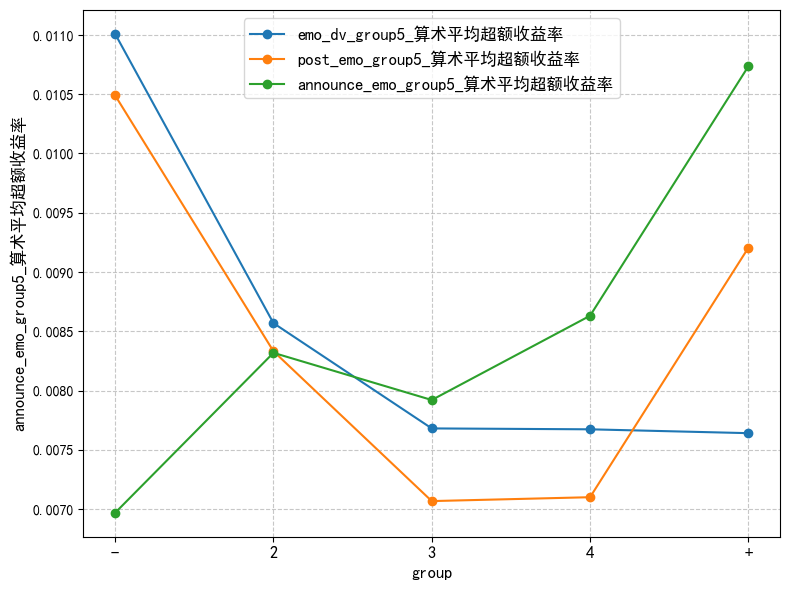

In [15]:
gp5_dv = calculate_results(divergence, 'emo_dv_group5')
gp5_post = calculate_results(divergence, 'post_emo_group5')
gp5_announce = calculate_results(divergence, 'announce_emo_group5')
plot_specified_column([gp5_dv,gp5_post,gp5_announce], 1) 

,emo_dv_group5_加权平均超额收益率,emo_dv_group5_方差,emo_dv_group5_夏普比,emo_dv_group5_收益率_t值,emo_dv_group5_收益率_p值
emo_dv_group5,,,,,
-,0.003393,0.003709,0.055713,0.695858,0.48756
2,0.004085,0.003744,0.066765,0.833898,0.405622
3,0.003286,0.004537,0.048783,0.609299,0.543218
4,0.005265,0.004610,0.077547,0.968558,0.334275
+,0.003677,0.003790,0.059730,0.746024,0.456783
hedge,-0.000284,0.000559,-0.012027,-0.150215,0.88079


,post_emo_group5_加权平均超额收益率,post_emo_group5_方差,post_emo_group5_夏普比,post_emo_group5_收益率_t值,post_emo_group5_收益率_p值
post_emo_group5,,,,,
-,0.005023,0.003923,0.080199,1.001686,0.318057
2,0.000030,0.003833,0.000483,0.00603,0.995196
3,0.008476,0.006271,0.107031,1.336818,0.183241
4,0.002962,0.004381,0.044748,0.558908,0.577031
+,0.003453,0.003454,0.058752,0.733815,0.46417
hedge,0.001570,0.000802,0.055462,0.692724,0.489519


,announce_emo_group5_加权平均超额收益率,announce_emo_group5_方差,announce_emo_group5_夏普比,announce_emo_group5_收益率_t值,announce_emo_group5_收益率_p值
announce_emo_group5,,,,,
-,0.002857,0.003387,0.049086,0.613081,0.540721
2,0.005590,0.003965,0.088781,1.108868,0.269205
3,0.004808,0.004182,0.074345,0.928564,0.354559
4,0.003188,0.004508,0.047478,0.592998,0.554047
+,0.004588,0.004418,0.069029,0.862177,0.389922
hedge,-0.001732,0.000910,-0.057397,-0.716894,0.474519


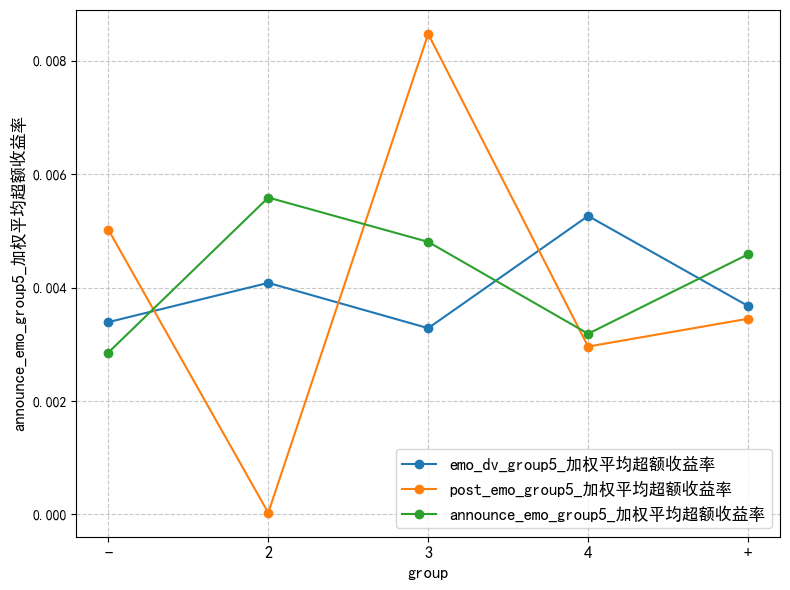

In [16]:
gp5_dv = calculate_results(divergence, 'emo_dv_group5','post_emo_weight5')
gp5_post = calculate_results(divergence, 'post_emo_group5', 'emo_dv_weight5')
gp5_announce = calculate_results(divergence, 'announce_emo_group5', 'announce_emo_weight5')
plot_specified_column([gp5_dv,gp5_post,gp5_announce], 1) 

## Step3：超额收益α检验
对五分组算术平均超额收益进行检验

In [17]:
FFFactor = pd.read_csv("E:\FF5.csv")
FFFactor['TradingMonth'] = pd.to_datetime(FFFactor['TradingMonth'], format='%Y-%m')
FFFactor = FFFactor[(FFFactor['MarkettypeID']=='P9714')& (FFFactor['Portfolios']==1)]
FFFactor = FFFactor.reset_index(drop = True)
FFFactor = FFFactor.rename(columns = {'TradingMonth':'month'})
display(FFFactor)

CHFactor = pd.read_excel(r"E:\CH.xlsx")
CHFactor['month'] = pd.to_datetime(CHFactor['month'], format='%Y-%m')
display(CHFactor)

,MarkettypeID,month,Portfolios,RiskPremium1,SMB1,HML1,RMW1,CMA1
0,P9714,2010-11-01,1,-0.049940,0.062281,-0.035990,0.016373,0.012258
1,P9714,2010-12-01,1,-0.007594,-0.005681,0.015797,0.005367,-0.017040
2,P9714,2011-01-01,1,-0.017814,-0.034425,0.040516,-0.009226,0.005638
3,P9714,2011-02-01,1,0.044323,0.054790,-0.030533,-0.040116,0.022328
4,P9714,2011-03-01,1,0.001873,0.017663,0.005710,-0.017481,0.006426
...,...,...,...,...,...,...,...,...
151,P9714,2023-06-01,1,0.011559,0.017546,-0.014614,0.015353,-0.008444
152,P9714,2023-07-01,1,0.034079,-0.026236,0.022162,-0.015374,0.026148
153,P9714,2023-08-01,1,-0.050368,0.014771,0.002148,0.003871,0.006052
154,P9714,2023-09-01,1,-0.005147,0.012936,0.017673,-0.005244,0.000004


,month,SMB,Rm-Rf,VMG,TO
0,2010-11-01,0.036993,-0.045532,0.005021,0.048626
1,2010-12-01,-0.013857,-0.010822,-0.017264,0.042922
2,2011-01-01,-0.020866,-0.022593,-0.036909,-0.014835
3,2011-02-01,0.039773,0.050719,0.044243,0.119426
4,2011-03-01,0.013540,-0.000179,0.000586,0.051559
...,...,...,...,...,...
151,2023-06-01,0.008584,0.014235,-0.014501,0.048765
152,2023-07-01,-0.011566,0.030921,-0.038585,-0.069907
153,2023-08-01,0.012822,-0.055323,-0.000622,-0.001914
154,2023-09-01,0.017078,-0.008278,-0.010721,0.028042


In [18]:
# Compute average excess returns for each group and each month
avg_returns_table = divergence.groupby(['emo_dv_group5', 'month'])['excess return'].mean().unstack()

# Compute monthly hedge returns
monthly_hedge_returns = divergence.groupby('month').apply(
    lambda x: x.loc[x['emo_dv_group5'] == '-', 'excess return'].mean() - x.loc[x['emo_dv_group5'] == '+', 'excess return'].mean()
)

# Convert hedge returns to DataFrame and transpose
monthly_hedge_returns_df = pd.DataFrame(monthly_hedge_returns, columns=['hedge']).T

# Combine average returns table with hedge returns
avg_returns_table_with_hedge = pd.concat([avg_returns_table, monthly_hedge_returns_df], axis=0)


def t_test_avg_returns(avg_returns_table_with_hedge):
    t_test_results = pd.DataFrame(columns=['group', 'alpha(×100)', 't-value', 'p-value'])

    for group in avg_returns_table_with_hedge.index:
        # 获取该组的平均回报数据
        data = avg_returns_table_with_hedge.loc[group].dropna()

        # 进行单样本t检验，检验均值是否为0
        t_stat, p_value = stats.ttest_1samp(data, 0)

        # 存储t值和p值
        results = pd.DataFrame({
            'group': [group],
            'alpha(×100)': [data.mean()*100],
            't-value': [t_stat],
            'p-value': [p_value]
        })
        t_test_results = pd.concat([t_test_results, results], ignore_index=True)

    return t_test_results

t_test_results = t_test_avg_returns(avg_returns_table_with_hedge)
print("raw return:")
display(t_test_results)

raw return:


,group,alpha(×100),t-value,p-value
0,-,1.100832,1.794091,0.074748
1,2,0.856846,1.423949,0.156471
2,3,0.768012,1.279748,0.202546
3,4,0.767259,1.310768,0.191875
4,+,0.764013,1.360223,0.175734
5,hedge,0.336818,2.810455,0.005586


In [19]:
def compute_OLS_results(factor_vars, divergence, model_name):
    # Prepare the factor variables DataFrame
    X = factor_vars
    X = sm.add_constant(X)

    # Initialize DataFrame to store OLS results
    ols_results_df = pd.DataFrame()

    # Perform regression for each group
    for group in avg_returns_table_with_hedge.index:
        y = avg_returns_table_with_hedge.loc[group].dropna()
        y_vec = y.values.flatten()

        # Generate design matrix for OLS
        X_mat = sm.add_constant(X[:len(y_vec)])  # Ensure X matches the length of y

        # Perform OLS regression if lengths match
        if len(y_vec) == X_mat.shape[0]:
            model = sm.OLS(y_vec, X_mat).fit()

            results = pd.DataFrame({
                'group': [group],
                'alpha(×100)': [model.params['const']*100],
                'std_err': [model.bse['const']],
                'R-squared': [model.rsquared],
                't-values': [model.tvalues['const']],
                'P-values': [model.pvalues['const']],
                'No. observations': [len(y_vec)]
            })
            ols_results_df = pd.concat([ols_results_df, results], ignore_index=True)
        else:
            print(f"Data mismatch for group {group}: skipping regression.")

    # Display OLS results
    print(model_name)
    display(ols_results_df)

    # Calculate and print the average absolute value of alpha
    Ar = np.mean(np.abs(ols_results_df['alpha(×100)']))
    print("Average |α| =", Ar)

    return ols_results_df, Ar




In [20]:
ols_results_df, Ar = compute_OLS_results(FFFactor[['RiskPremium1']], divergence, "CAPM模型:")
ols_results_df, Ar = compute_OLS_results(FFFactor[['RiskPremium1','SMB1','HML1','RMW1','CMA1']], divergence, "FF模型:")
ols_results_df, Ar = compute_OLS_results(CHFactor[['Rm-Rf','SMB','VMG']], divergence, "CH3模型:")
ols_results_df, Ar = compute_OLS_results(CHFactor[['Rm-Rf','SMB','VMG', 'TO']], divergence, "CH4模型:")

CAPM模型:


,group,alpha(×100),std_err,R-squared,t-values,P-values,No. observations
0,-,1.041682,0.006090,0.023743,1.710503,0.089187,156
1,2,0.802982,0.005982,0.020472,1.342259,0.181487,156
2,3,0.708103,0.005951,0.025462,1.189873,0.235927,156
3,4,0.717904,0.005826,0.018164,1.232191,0.219756,156
4,+,0.719636,0.005597,0.015949,1.285762,0.200456,156
5,hedge,0.322046,0.001180,0.038820,2.728622,0.007100,156


Average |α| = 0.7187257656057877
FF模型:


,group,alpha(×100),std_err,R-squared,t-values,P-values,No. observations
0,-,1.536073,0.006378,0.062255,2.408263,0.017242,156
1,2,1.271978,0.006272,0.057347,2.028181,0.044312,156
2,3,1.174016,0.006237,0.062785,1.882444,0.061712,156
3,4,1.163717,0.006106,0.055792,1.905935,0.058571,156
4,+,1.194804,0.005844,0.060469,2.044379,0.042665,156
5,hedge,0.341269,0.001225,0.092808,2.785092,0.006042,156


Average |α| = 1.1136429917638184
CH3模型:


,group,alpha(×100),std_err,R-squared,t-values,P-values,No. observations
0,-,1.328855,0.006167,0.053320,2.154628,0.032766,156
1,2,1.093898,0.006052,0.052227,1.807545,0.072655,156
2,3,1.007931,0.006013,0.059283,1.676218,0.095751,156
3,4,1.007103,0.005889,0.051572,1.710126,0.089283,156
4,+,1.019099,0.005640,0.055189,1.806866,0.072761,156
5,hedge,0.309756,0.001210,0.045612,2.561009,0.011411,156


Average |α| = 0.9611071035088058
CH4模型:


,group,alpha(×100),std_err,R-squared,t-values,P-values,No. observations
0,-,1.125085,0.008829,0.053976,1.274365,0.204492,156
1,2,0.889324,0.008663,0.052914,1.026582,0.306259,156
2,3,0.708920,0.008604,0.060759,0.823951,0.411267,156
3,4,0.684992,0.008425,0.053372,0.813047,0.417471,156
4,+,0.796503,0.008073,0.056123,0.986678,0.325379,156
5,hedge,0.328582,0.001732,0.045759,1.897280,0.059700,156


Average |α| = 0.7555677303333747


## Step4: Double Sorting

In [21]:
DbSt_df = divergence[['Stkcd','month', 'RCA','AG','ROA','BM','Size','MOM','excess return', 'emo_dv','emo_dv_group5']]
DbSt_df = DbSt_df[(DbSt_df['emo_dv_group5'] == '-') | (DbSt_df['emo_dv_group5'] == '+')]
DbSt_df = pd.merge(DbSt_df, FFFactor, on ='month')
DbSt_df = pd.merge(DbSt_df, CHFactor, on ='month')
display(DbSt_df)

,Stkcd,month,RCA,AG,ROA,BM,Size,MOM,excess return,emo_dv,emo_dv_group5,MarkettypeID,Portfolios,RiskPremium1,SMB1,HML1,RMW1,CMA1,SMB,Rm-Rf,VMG,TO
0,000002,2013-01-01,0.000883,0.373640,0.045325,0.734139,8.608689e+10,0.143791,0.140183,0.372211,+,P9714,1,0.050566,0.025284,0.014964,-0.035186,0.008776,0.024576,0.048680,0.032252,0.087842
1,000006,2013-01-01,0.000291,-0.028749,0.051404,0.705270,5.557890e+09,-0.120729,-0.138742,0.697364,+,P9714,1,0.050566,0.025284,0.014964,-0.035186,0.008776,0.024576,0.048680,0.032252,0.087842
2,000014,2013-01-01,0.000255,0.130557,0.038165,0.567087,1.956540e+09,0.310484,-0.003495,2.445107,+,P9714,1,0.050566,0.025284,0.014964,-0.035186,0.008776,0.024576,0.048680,0.032252,0.087842
3,000019,2013-01-01,0.035558,0.612778,0.011210,0.816160,1.221668e+09,-0.098592,-0.052405,-2.000663,-,P9714,1,0.050566,0.025284,0.014964,-0.035186,0.008776,0.024576,0.048680,0.032252,0.087842
4,000020,2013-01-01,0.026718,-0.079225,0.014882,0.812520,4.643701e+08,-0.034735,-0.000837,0.783386,+,P9714,1,0.050566,0.025284,0.014964,-0.035186,0.008776,0.024576,0.048680,0.032252,0.087842
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
132041,603898,2017-12-01,0.087152,0.353478,0.184573,0.410327,3.110690e+09,-0.090207,0.000768,-2.344585,-,P9714,1,0.003557,-0.024180,-0.004586,0.018863,-0.019675,-0.022959,-0.000355,-0.016212,0.032272
132042,603918,2017-12-01,0.019052,0.036889,0.036496,0.132875,3.329055e+09,-0.281728,0.303077,-5.143239,-,P9714,1,0.003557,-0.024180,-0.004586,0.018863,-0.019675,-0.022959,-0.000355,-0.016212,0.032272
132043,603988,2017-12-01,0.009879,0.036499,0.029094,0.424449,1.396864e+09,0.050920,-0.254790,-1.870740,-,P9714,1,0.003557,-0.024180,-0.004586,0.018863,-0.019675,-0.022959,-0.000355,-0.016212,0.032272
132044,603993,2017-12-01,0.009691,1.854447,0.017126,0.388854,6.554588e+10,0.927419,-0.199193,1.353117,+,P9714,1,0.003557,-0.024180,-0.004586,0.018863,-0.019675,-0.022959,-0.000355,-0.016212,0.032272


In [22]:
def categorize_and_combine_labels(DbSt_df, column_name):
    # Step 1: Calculate the 30th and 70th percentiles
    low_threshold = DbSt_df[column_name].quantile(0.3)
    high_threshold = DbSt_df[column_name].quantile(0.7)
    
    # Step 2: Create High and Low categories, discard middle group
    conditions = [
        (DbSt_df[column_name] <= low_threshold),
        (DbSt_df[column_name] > high_threshold)
    ]
    choices = ['Low', 'High']
    DbSt_df['Category'] = pd.Series(pd.cut(DbSt_df[column_name], 
                                           bins=[-float('inf'), low_threshold, high_threshold, float('inf')],
                                           labels=['Low', 'Mid', 'High']).astype(str))
    DbSt_df.loc[DbSt_df['Category'] == 'Mid', 'Category'] = np.nan

    # Step 3: Combine the new label with 'emo_dv_group5'
    combined_label_column = f"{column_name}-emo_dv_group"
    DbSt_df[combined_label_column] = DbSt_df['Category'] + '-' + DbSt_df['emo_dv_group5'].astype(str)

    # Drop the temporary 'Category' column
    DbSt_df.drop(columns=['Category'], inplace=True)
    
    return DbSt_df


DbSt_df = categorize_and_combine_labels(DbSt_df, 'RCA')
DbSt_df = categorize_and_combine_labels(DbSt_df, 'AG')
DbSt_df = categorize_and_combine_labels(DbSt_df, 'ROA')
DbSt_df = categorize_and_combine_labels(DbSt_df, 'BM')
DbSt_df = categorize_and_combine_labels(DbSt_df, 'Size')
DbSt_df = categorize_and_combine_labels(DbSt_df, 'MOM')


display(DbSt_df)

,Stkcd,month,RCA,AG,ROA,BM,Size,MOM,excess return,emo_dv,emo_dv_group5,MarkettypeID,Portfolios,RiskPremium1,SMB1,HML1,RMW1,CMA1,SMB,Rm-Rf,VMG,TO,RCA-emo_dv_group,AG-emo_dv_group,ROA-emo_dv_group,BM-emo_dv_group,Size-emo_dv_group,MOM-emo_dv_group
0,000002,2013-01-01,0.000883,0.373640,0.045325,0.734139,8.608689e+10,0.143791,0.140183,0.372211,+,P9714,1,0.050566,0.025284,0.014964,-0.035186,0.008776,0.024576,0.048680,0.032252,0.087842,Low-+,High-+,NaN,High-+,High-+,High-+
1,000006,2013-01-01,0.000291,-0.028749,0.051404,0.705270,5.557890e+09,-0.120729,-0.138742,0.697364,+,P9714,1,0.050566,0.025284,0.014964,-0.035186,0.008776,0.024576,0.048680,0.032252,0.087842,Low-+,Low-+,NaN,NaN,NaN,NaN
2,000014,2013-01-01,0.000255,0.130557,0.038165,0.567087,1.956540e+09,0.310484,-0.003495,2.445107,+,P9714,1,0.050566,0.025284,0.014964,-0.035186,0.008776,0.024576,0.048680,0.032252,0.087842,Low-+,NaN,NaN,NaN,Low-+,High-+
3,000019,2013-01-01,0.035558,0.612778,0.011210,0.816160,1.221668e+09,-0.098592,-0.052405,-2.000663,-,P9714,1,0.050566,0.025284,0.014964,-0.035186,0.008776,0.024576,0.048680,0.032252,0.087842,NaN,High--,Low--,High--,Low--,NaN
4,000020,2013-01-01,0.026718,-0.079225,0.014882,0.812520,4.643701e+08,-0.034735,-0.000837,0.783386,+,P9714,1,0.050566,0.025284,0.014964,-0.035186,0.008776,0.024576,0.048680,0.032252,0.087842,NaN,Low-+,Low-+,High-+,Low-+,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
132041,603898,2017-12-01,0.087152,0.353478,0.184573,0.410327,3.110690e+09,-0.090207,0.000768,-2.344585,-,P9714,1,0.003557,-0.024180,-0.004586,0.018863,-0.019675,-0.022959,-0.000355,-0.016212,0.032272,High--,High--,High--,NaN,NaN,NaN
132042,603918,2017-12-01,0.019052,0.036889,0.036496,0.132875,3.329055e+09,-0.281728,0.303077,-5.143239,-,P9714,1,0.003557,-0.024180,-0.004586,0.018863,-0.019675,-0.022959,-0.000355,-0.016212,0.032272,Low--,NaN,NaN,Low--,NaN,Low--
132043,603988,2017-12-01,0.009879,0.036499,0.029094,0.424449,1.396864e+09,0.050920,-0.254790,-1.870740,-,P9714,1,0.003557,-0.024180,-0.004586,0.018863,-0.019675,-0.022959,-0.000355,-0.016212,0.032272,Low--,NaN,NaN,NaN,Low--,NaN
132044,603993,2017-12-01,0.009691,1.854447,0.017126,0.388854,6.554588e+10,0.927419,-0.199193,1.353117,+,P9714,1,0.003557,-0.024180,-0.004586,0.018863,-0.019675,-0.022959,-0.000355,-0.016212,0.032272,Low-+,High-+,Low-+,NaN,High-+,High-+


In [23]:
def t_test_grouped(DbSt_df, group_name):
    # Group by the specified group_name and month
    grouped = DbSt_df.groupby([group_name, 'month'])

    # Calculate the mean excess return for each group
    mean_returns = grouped['excess return'].mean().reset_index()

    # Group by the specified group_name again to perform the t-test
    grouped_mean = mean_returns.groupby(group_name)

    # Prepare a list to collect t-test results
    results = []

    # Perform t-test for each group
    for name, group in grouped_mean:
        t_stat, p_value = ttest_1samp(group['excess return'], 0)
        results.append((name, group['excess return'].mean()*100, t_stat, p_value))
    
    # Calculate High-hedge and Low-hedge excess return
    high_hedge_results = []
    low_hedge_results = []

    for month in mean_returns['month'].unique():
        high_minus_minus = mean_returns[(mean_returns['month'] == month) & (mean_returns[group_name] == 'High--')]
        high_plus = mean_returns[(mean_returns['month'] == month) & (mean_returns[group_name] == 'High-+')]
        low_minus = mean_returns[(mean_returns['month'] == month) & (mean_returns[group_name] == 'Low--')]
        low_plus = mean_returns[(mean_returns['month'] == month) & (mean_returns[group_name] == 'Low-+')]
        
        if not high_minus_minus.empty and not high_plus.empty:
            high_hedge_return = high_plus['excess return'].values[0] - high_minus_minus['excess return'].values[0]
            high_hedge_results.append(high_hedge_return)
        
        if not low_minus.empty and not low_plus.empty:
            low_hedge_return = low_plus['excess return'].values[0] - low_minus['excess return'].values[0]
            low_hedge_results.append(low_hedge_return)

    # Perform t-test on High-hedge and Low-hedge excess return
    if high_hedge_results:
        high_hedge_t_stat, high_hedge_p_value = ttest_1samp(high_hedge_results, 0)
        results.append(('High-hedge', pd.Series(high_hedge_results).mean()*100, high_hedge_t_stat, high_hedge_p_value))
    if low_hedge_results:
        low_hedge_t_stat, low_hedge_p_value = ttest_1samp(low_hedge_results, 0)
        results.append(('Low-hedge', pd.Series(low_hedge_results).mean()*100, low_hedge_t_stat, low_hedge_p_value))

    # Convert results to DataFrame for better readability
    results_df = pd.DataFrame(results, columns=[group_name, 'alpha(×100)', 't_stat', 'p_value'])

    print(f"{group_name} double sorting with High-hedge and Low-hedge:")
    display(results_df)


def ols_t_test_grouped(DbSt_df, group_name, X_df, model_name):
    # Group by the specified group_name and month
    grouped = DbSt_df.groupby([group_name, 'month'])

    # Calculate the mean excess return for each group
    mean_returns = grouped['excess return'].mean().reset_index()

    # Prepare a list to collect OLS regression results
    results = []

    # Perform OLS regression for each group
    for name, group in mean_returns.groupby(group_name):
        y = group['excess return'].reset_index(drop=True)
        # Ensure the X_df has the same number of rows as unique months in the group
        X = X_df[X_df['month'].isin(group['month'])]

        # Ensure X is aligned with y by month
        X = X.set_index('month').reindex(group['month']).reset_index(drop=True)

        if len(X) == len(y):
            # Add a constant (intercept) to the model
            X = sm.add_constant(X)

            # Fit the OLS model
            model = sm.OLS(y, X).fit()

            # Get the constant (intercept) t-value and p-value
            const_param = model.params['const']
            t_stat = model.tvalues['const']
            p_value = model.pvalues['const']
            results.append((name, const_param*100, t_stat, p_value))
        else:
            print(f"Mismatch in length for group {name}: len(X)={len(X)}, len(y)={len(y)}")

    # Calculate High-hedge and Low-hedge excess return
    high_hedge_results = []
    low_hedge_results = []

    for month in mean_returns['month'].unique():
        high_minus_minus = mean_returns[(mean_returns['month'] == month) & (mean_returns[group_name] == 'High--')]
        high_plus = mean_returns[(mean_returns['month'] == month) & (mean_returns[group_name] == 'High-+')]
        low_minus_minus = mean_returns[(mean_returns['month'] == month) & (mean_returns[group_name] == 'Low--')]
        low_plus = mean_returns[(mean_returns['month'] == month) & (mean_returns[group_name] == 'Low-+')]
        
        if not high_minus_minus.empty and not high_plus.empty:
            high_hedge_return = high_plus['excess return'].values[0] - high_minus_minus['excess return'].values[0]
            high_hedge_results.append((month, high_hedge_return))
        
        if not low_minus_minus.empty and not low_plus.empty:
            low_hedge_return = low_plus['excess return'].values[0] - low_minus_minus['excess return'].values[0]
            low_hedge_results.append((month, low_hedge_return))

    # Convert hedge results to DataFrame
    high_hedge_df = pd.DataFrame(high_hedge_results, columns=['month', 'high_hedge_excess_return'])
    low_hedge_df = pd.DataFrame(low_hedge_results, columns=['month', 'low_hedge_excess_return'])

    # Perform OLS regression on High-hedge and Low-hedge excess return
    if not high_hedge_df.empty:
        y_high_hedge = high_hedge_df['high_hedge_excess_return']
        X_high_hedge = X_df[X_df['month'].isin(high_hedge_df['month'])]

        # Ensure X_high_hedge is aligned with y_high_hedge by month
        X_high_hedge = X_high_hedge.set_index('month').reindex(high_hedge_df['month']).reset_index(drop=True)

        if len(X_high_hedge) == len(y_high_hedge):
            # Add a constant (intercept) to the model
            X_high_hedge = sm.add_constant(X_high_hedge)

            # Fit the OLS model
            high_hedge_model = sm.OLS(y_high_hedge, X_high_hedge).fit()

            # Get the constant (intercept) t-value and p-value
            const_param_high_hedge = high_hedge_model.params['const']
            t_stat_high_hedge = high_hedge_model.tvalues['const']
            p_value_high_hedge = high_hedge_model.pvalues['const']
            results.append(('High-hedge', const_param_high_hedge*100, t_stat_high_hedge, p_value_high_hedge))
        else:
            print(f"Mismatch in length for high hedge: len(X_high_hedge)={len(X_high_hedge)}, len(y_high_hedge)={len(y_high_hedge)}")

    if not low_hedge_df.empty:
        y_low_hedge = low_hedge_df['low_hedge_excess_return']
        X_low_hedge = X_df[X_df['month'].isin(low_hedge_df['month'])]

        # Ensure X_low_hedge is aligned with y_low_hedge by month
        X_low_hedge = X_low_hedge.set_index('month').reindex(low_hedge_df['month']).reset_index(drop=True)

        if len(X_low_hedge) == len(y_low_hedge):
            # Add a constant (intercept) to the model
            X_low_hedge = sm.add_constant(X_low_hedge)

            # Fit the OLS model
            low_hedge_model = sm.OLS(y_low_hedge, X_low_hedge).fit()

            # Get the constant (intercept) t-value and p-value
            const_param_low_hedge = low_hedge_model.params['const']
            t_stat_low_hedge = low_hedge_model.tvalues['const']
            p_value_low_hedge = low_hedge_model.pvalues['const']
            results.append(('Low-hedge', const_param_low_hedge*100, t_stat_low_hedge, p_value_low_hedge))
        else:
            print(f"Mismatch in length for low hedge: len(X_low_hedge)={len(X_low_hedge)}, len(y_low_hedge)={len(y_low_hedge)}")

    # Convert results to DataFrame for better readability
    results_df = pd.DataFrame(results, columns=[group_name, 'const_param(×100)', 't_stat', 'p_value'])


    print(f"{group_name} OLS t-test results under {model_name}:")
    display(results_df)

    
def double_sorting_under_different_model(group_name):
    t_test_grouped(DbSt_df, group_name)
    ols_t_test_grouped(DbSt_df, group_name, FFFactor[['month','RiskPremium1']], 'CAPM模型:')
    ols_t_test_grouped(DbSt_df, group_name, FFFactor[['month','RiskPremium1','SMB1','HML1','RMW1','CMA1']], 'FF5模型:')
    ols_t_test_grouped(DbSt_df, group_name, CHFactor[['month','Rm-Rf','SMB','VMG']], 'CH3模型:')
    ols_t_test_grouped(DbSt_df, group_name, CHFactor[['month','Rm-Rf','SMB','VMG','TO']], 'CH4模型:')


In [24]:
double_sorting_under_different_model('RCA-emo_dv_group')
double_sorting_under_different_model('AG-emo_dv_group')
double_sorting_under_different_model('ROA-emo_dv_group')
double_sorting_under_different_model('BM-emo_dv_group')
double_sorting_under_different_model('Size-emo_dv_group')
double_sorting_under_different_model('MOM-emo_dv_group')

RCA-emo_dv_group double sorting with High-hedge and Low-hedge:


,RCA-emo_dv_group,alpha(×100),t_stat,p_value
0,High-+,0.779249,1.366887,0.173640
1,High--,1.103664,1.767453,0.079120
2,Low-+,0.788644,1.387556,0.167264
3,Low--,0.979786,1.631400,0.104836
4,High-hedge,-0.324415,-1.930064,0.055425
5,Low-hedge,-0.191142,-1.082810,0.280574


RCA-emo_dv_group OLS t-test results under CAPM模型::


,RCA-emo_dv_group,const_param(×100),t_stat,p_value
0,High-+,0.729306,1.286215,0.200299
1,High--,1.033910,1.675238,0.095917
2,Low-+,0.754655,1.327879,0.186183
3,Low--,0.938583,1.565222,0.119584
4,High-hedge,-0.304603,-1.836963,0.068143
5,Low-hedge,-0.183927,-1.039481,0.300210


RCA-emo_dv_group OLS t-test results under FF5模型::


,RCA-emo_dv_group,const_param(×100),t_stat,p_value
0,High-+,1.254803,2.134211,0.034451
1,High--,1.521133,2.350757,0.020037
2,Low-+,1.232630,2.074648,0.039728
3,Low--,1.380299,2.192703,0.029869
4,High-hedge,-0.266329,-1.551327,0.122931
5,Low-hedge,-0.147669,-0.808653,0.419995


RCA-emo_dv_group OLS t-test results under CH3模型::


,RCA-emo_dv_group,const_param(×100),t_stat,p_value
0,High-+,1.094588,1.934134,0.054954
1,High--,1.326725,2.123016,0.035372
2,Low-+,1.025951,1.784156,0.076393
3,Low--,1.199453,1.971972,0.050428
4,High-hedge,-0.232136,-1.382779,0.168761
5,Low-hedge,-0.173503,-0.954880,0.341154


RCA-emo_dv_group OLS t-test results under CH4模型::


,RCA-emo_dv_group,const_param(×100),t_stat,p_value
0,High-+,1.134270,1.399660,0.163666
1,High--,1.347831,1.506167,0.134113
2,Low-+,0.585507,0.712380,0.477329
3,Low--,0.987511,1.134202,0.258507
4,High-hedge,-0.213561,-0.888409,0.375734
5,Low-hedge,-0.402004,-1.552837,0.122555


AG-emo_dv_group double sorting with High-hedge and Low-hedge:


,AG-emo_dv_group,alpha(×100),t_stat,p_value
0,High-+,0.622332,1.072316,0.285245
1,High--,0.829639,1.326087,0.186762
2,Low-+,0.736983,1.307992,0.192812
3,Low--,1.189816,1.915615,0.057255
4,High-hedge,-0.207307,-1.350855,0.178711
5,Low-hedge,-0.452833,-2.785304,0.006015


AG-emo_dv_group OLS t-test results under CAPM模型::


,AG-emo_dv_group,const_param(×100),t_stat,p_value
0,High-+,0.570177,0.988291,0.324560
1,High--,0.768372,1.237908,0.217634
2,Low-+,0.703163,1.248127,0.213879
3,Low--,1.133570,1.836208,0.068255
4,High-hedge,-0.198195,-1.291515,0.198460
5,Low-hedge,-0.430408,-2.701983,0.007666


AG-emo_dv_group OLS t-test results under FF5模型::


,AG-emo_dv_group,const_param(×100),t_stat,p_value
0,High-+,1.090481,1.819215,0.070873
1,High--,1.222239,1.873122,0.062997
2,Low-+,1.149022,1.948119,0.053268
3,Low--,1.596783,2.463026,0.014908
4,High-hedge,-0.131758,-0.830921,0.407339
5,Low-hedge,-0.447761,-2.692507,0.007898


AG-emo_dv_group OLS t-test results under CH3模型::


,AG-emo_dv_group,const_param(×100),t_stat,p_value
0,High-+,0.927644,1.607066,0.110115
1,High--,1.036087,1.643794,0.102286
2,Low-+,0.971877,1.706031,0.090045
3,Low--,1.414628,2.260505,0.025210
4,High-hedge,-0.108443,-0.705345,0.481675
5,Low-hedge,-0.442751,-2.724276,0.007200


AG-emo_dv_group OLS t-test results under CH4模型::


,AG-emo_dv_group,const_param(×100),t_stat,p_value
0,High-+,0.942389,1.140110,0.256046
1,High--,1.030295,1.141501,0.255469
2,Low-+,0.645641,0.792288,0.429436
3,Low--,1.026753,1.147157,0.253131
4,High-hedge,-0.087906,-0.399307,0.690231
5,Low-hedge,-0.381112,-1.638348,0.103431


ROA-emo_dv_group double sorting with High-hedge and Low-hedge:


,ROA-emo_dv_group,alpha(×100),t_stat,p_value
0,High-+,0.712724,1.296806,0.196625
1,High--,0.879047,1.483670,0.139927
2,Low-+,0.735486,1.241335,0.216357
3,Low--,1.171461,1.814608,0.071518
4,High-hedge,-0.166323,-1.193230,0.234602
5,Low-hedge,-0.435975,-2.666416,0.008480


ROA-emo_dv_group OLS t-test results under CAPM模型::


,ROA-emo_dv_group,const_param(×100),t_stat,p_value
0,High-+,0.666121,1.217811,0.225158
1,High--,0.824406,1.400504,0.163374
2,Low-+,0.680528,1.156203,0.249389
3,Low--,1.111749,1.733436,0.085020
4,High-hedge,-0.158286,-1.135304,0.258012
5,Low-hedge,-0.431221,-2.628348,0.009449


ROA-emo_dv_group OLS t-test results under FF5模型::


,ROA-emo_dv_group,const_param(×100),t_stat,p_value
0,High-+,1.196819,2.114178,0.036154
1,High--,1.339201,2.180647,0.030768
2,Low-+,1.097875,1.774079,0.078079
3,Low--,1.557566,2.308102,0.022360
4,High-hedge,-0.142382,-0.970766,0.333227
5,Low-hedge,-0.459691,-2.642268,0.009109


ROA-emo_dv_group OLS t-test results under CH3模型::


,ROA-emo_dv_group,const_param(×100),t_stat,p_value
0,High-+,1.003503,1.833386,0.068701
1,High--,1.105277,1.855302,0.065490
2,Low-+,0.955294,1.603030,0.111004
3,Low--,1.390703,2.136829,0.034212
4,High-hedge,-0.101774,-0.719838,0.472730
5,Low-hedge,-0.435408,-2.583782,0.010714


ROA-emo_dv_group OLS t-test results under CH4模型::


,ROA-emo_dv_group,const_param(×100),t_stat,p_value
0,High-+,0.962381,1.227874,0.221405
1,High--,1.168785,1.370117,0.172684
2,Low-+,0.558059,0.654879,0.513542
3,Low--,1.003722,1.078202,0.282663
4,High-hedge,-0.206404,-1.021261,0.308764
5,Low-hedge,-0.445663,-1.846862,0.066724


BM-emo_dv_group double sorting with High-hedge and Low-hedge:


,BM-emo_dv_group,alpha(×100),t_stat,p_value
0,High-+,0.933485,1.710685,0.089140
1,High--,1.421302,2.370217,0.019008
2,Low-+,0.555227,0.930244,0.353691
3,Low--,0.785518,1.266014,0.207407
4,High-hedge,-0.487817,-2.607021,0.010025
5,Low-hedge,-0.230290,-1.479425,0.141056


BM-emo_dv_group OLS t-test results under CAPM模型::


,BM-emo_dv_group,const_param(×100),t_stat,p_value
0,High-+,0.880257,1.625786,0.106040
1,High--,1.357134,2.286753,0.023573
2,Low-+,0.503702,0.848245,0.397618
3,Low--,0.730603,1.184135,0.238184
4,High-hedge,-0.476877,-2.548273,0.011805
5,Low-hedge,-0.226901,-1.451991,0.148538


BM-emo_dv_group OLS t-test results under FF5模型::


,BM-emo_dv_group,const_param(×100),t_stat,p_value
0,High-+,1.301936,2.295304,0.023102
1,High--,1.771385,2.835153,0.005213
2,Low-+,1.045327,1.693464,0.092443
3,Low--,1.242674,1.924728,0.056156
4,High-hedge,-0.469449,-2.378196,0.018657
5,Low-hedge,-0.197346,-1.203524,0.230670


BM-emo_dv_group OLS t-test results under CH3模型::


,BM-emo_dv_group,const_param(×100),t_stat,p_value
0,High-+,1.126711,2.054049,0.041684
1,High--,1.569212,2.593951,0.010416
2,Low-+,0.858304,1.441757,0.151428
3,Low--,1.017171,1.627409,0.105721
4,High-hedge,-0.442501,-2.304786,0.022532
5,Low-hedge,-0.158867,-1.002674,0.317612


BM-emo_dv_group OLS t-test results under CH4模型::


,BM-emo_dv_group,const_param(×100),t_stat,p_value
0,High-+,0.736316,0.938912,0.349275
1,High--,1.109785,1.283448,0.201301
2,Low-+,0.655098,0.768743,0.443246
3,Low--,1.054022,1.177663,0.240784
4,High-hedge,-0.373468,-1.358977,0.176180
5,Low-hedge,-0.398925,-1.771192,0.078546


Size-emo_dv_group double sorting with High-hedge and Low-hedge:


,Size-emo_dv_group,alpha(×100),t_stat,p_value
0,High-+,0.273580,0.548083,0.584423
1,High--,0.334249,0.611723,0.541617
2,Low-+,1.254055,1.896893,0.059702
3,Low--,2.027486,2.686995,0.007997
4,High-hedge,-0.060670,-0.357600,0.721129
5,Low-hedge,-0.773431,-3.229889,0.001512


Size-emo_dv_group OLS t-test results under CAPM模型::


,Size-emo_dv_group,const_param(×100),t_stat,p_value
0,High-+,0.243185,0.487319,0.626726
1,High--,0.289502,0.532030,0.595472
2,Low-+,1.179354,1.805590,0.072936
3,Low--,1.954606,2.610080,0.009946
4,High-hedge,-0.046318,-0.274299,0.784222
5,Low-hedge,-0.775252,-3.223205,0.001547


Size-emo_dv_group OLS t-test results under FF5模型::


,Size-emo_dv_group,const_param(×100),t_stat,p_value
0,High-+,0.603479,1.154281,0.250221
1,High--,0.673501,1.179100,0.240225
2,Low-+,1.703852,2.491511,0.013809
3,Low--,2.521151,3.211943,0.001614
4,High-hedge,-0.070022,-0.399517,0.690081
5,Low-hedge,-0.817299,-3.211949,0.001613


Size-emo_dv_group OLS t-test results under CH3模型::


,Size-emo_dv_group,const_param(×100),t_stat,p_value
0,High-+,0.494526,0.981083,0.328111
1,High--,0.492533,0.889859,0.374948
2,Low-+,1.448710,2.183297,0.030548
3,Low--,2.258166,2.968358,0.003480
4,High-hedge,0.001993,0.011910,0.990513
5,Low-hedge,-0.809456,-3.278181,0.001295


Size-emo_dv_group OLS t-test results under CH4模型::


,Size-emo_dv_group,const_param(×100),t_stat,p_value
0,High-+,0.311263,0.431409,0.666786
1,High--,0.537529,0.678205,0.498680
2,Low-+,1.420314,1.494796,0.137055
3,Low--,2.205063,2.024192,0.044713
4,High-hedge,-0.226266,-0.949830,0.343717
5,Low-hedge,-0.784749,-2.219461,0.027946


MOM-emo_dv_group double sorting with High-hedge and Low-hedge:


,MOM-emo_dv_group,alpha(×100),t_stat,p_value
0,High-+,1.148174,1.821719,0.070425
1,High--,1.003950,1.609819,0.109472
2,Low-+,0.894706,1.378903,0.169924
3,Low--,0.674341,1.019867,0.309381
4,High-hedge,0.144224,0.570603,0.569095
5,Low-hedge,0.087224,0.330320,0.741607


MOM-emo_dv_group OLS t-test results under CAPM模型::


,MOM-emo_dv_group,const_param(×100),t_stat,p_value
0,High-+,1.101410,1.752047,0.081756
1,High--,0.955186,1.536805,0.126393
2,Low-+,0.808972,1.255308,0.211281
3,Low--,0.599391,0.917634,0.360245
4,High-hedge,0.146224,0.575968,0.565478
5,Low-hedge,0.081718,0.307845,0.758619


MOM-emo_dv_group OLS t-test results under FF5模型::


,MOM-emo_dv_group,const_param(×100),t_stat,p_value
0,High-+,1.797546,2.788496,0.005982
1,High--,1.466883,2.255116,0.025573
2,Low-+,1.308503,1.941268,0.054113
3,Low--,1.066587,1.554849,0.122089
4,High-hedge,0.330663,1.264494,0.208014
5,Low-hedge,0.100642,0.359988,0.719366


MOM-emo_dv_group OLS t-test results under CH3模型::


,MOM-emo_dv_group,const_param(×100),t_stat,p_value
0,High-+,1.510290,2.409499,0.017170
1,High--,1.272684,2.028461,0.044259
2,Low-+,1.131008,1.736587,0.084500
3,Low--,0.874581,1.318185,0.189425
4,High-hedge,0.237606,0.919472,0.359306
5,Low-hedge,0.096095,0.351851,0.725441


MOM-emo_dv_group OLS t-test results under CH4模型::


,MOM-emo_dv_group,const_param(×100),t_stat,p_value
0,High-+,1.186242,1.322733,0.187924
1,High--,1.172632,1.305289,0.193780
2,Low-+,0.832533,0.897135,0.371084
3,Low--,0.684998,0.721178,0.471915
4,High-hedge,0.013610,0.036867,0.970640
5,Low-hedge,0.045676,0.117308,0.906773


## Step5：Fama-MacBeth Regression

divergence存储了‘month’列（按照这个分组），存储了‘excess return’列作为因变量，emo_dv, RCA, AG, ROA, BM, Size作为自变量逐个加入回归。这样的话，假如我们有n个组（也就是n个月的时间截面），那么我们就得到了n组回归系数。我们要对这些回归系数进行描述性统计和t检验。

调节异方差回归

In [25]:
# 存储回归系数和调整后的t值的字典
coefficients = {}
adjusted_t_values = {}

# 计算lags
T = 156
lags = int(4 * (T / 100) ** (2 / 9))+1
print("lags=",lags)
# 按月进行回归分析
for month in divergence['month'].unique():
    df_month = divergence[divergence['month'] == month]
    # 初始时只包含 emo_dv 列
    X = df_month[['emo_dv']]
    X = sm.add_constant(X)  # 添加常数项
    X = X.replace([np.inf, -np.inf], np.nan).fillna(0)
    
    y = df_month['excess return'].fillna(0)
    model = sm.OLS(y, X).fit(cov_type='HAC', cov_kwds={'maxlags': lags})
    
    # 记录初始emo_dv的系数和调整后的t值
    if 'step_1_emo_dv' not in coefficients:
        coefficients['step_1_emo_dv'] = []
        adjusted_t_values['step_1_emo_dv'] = []
    
    coefficients['step_1_emo_dv'].append(model.params['emo_dv'])
    adjusted_t_values['step_1_emo_dv'].append(model.tvalues['emo_dv'])
    
    variables = ['RCA', 'AG', 'ROA', 'BM', 'Size', 'MOM']
    for i, var in enumerate(variables):
        X = pd.concat([X, df_month[[var]]], axis=1)  # 每次迭代添加一个变量列
        X = X.replace([np.inf, -np.inf], np.nan).fillna(0)
        #display(X)
        #Separate the constant term
        X_const = X[['const']]
        X_vars = X.drop(columns=['const'])
        
        # Normalize the features except the constant term
        scaler = StandardScaler()
        X_vars_scaled = pd.DataFrame(scaler.fit_transform(X_vars), columns=X_vars.columns, index=X_vars.index)

        # Combine the constant term and the normalized features
        X = pd.concat([X_const, X_vars_scaled], axis=1)
        #display(X)
        y = df_month['excess return'].fillna(0)
        model = sm.OLS(y, X).fit(cov_type='HAC', cov_kwds={'maxlags': lags})
        if i != len(variables) - 1:
            step_key1 = f'step_{i+2}_{var}'
            step_key2 = f'step_{i+2}_emo_dv'
            if step_key1 not in coefficients:
                coefficients[step_key1] = []
                adjusted_t_values[step_key1] = []
            
            if step_key2 not in coefficients:
                coefficients[step_key2] = []
                adjusted_t_values[step_key2] = []
            
            coefficients[step_key2].append(model.params['emo_dv'])
            coefficients[step_key1].append(model.params[var])
            #adjusted_t_values[step_key2].append(model.tvalues['emo_dv'])
            #adjusted_t_values[step_key1].append(model.tvalues[var])
            
        elif i == len(variables) - 1:
            for final_var in ['emo_dv'] + variables:
                final_step_key = f'step_{i+2}_{final_var}'
                if final_step_key not in coefficients:
                    coefficients[final_step_key] = []
                    #adjusted_t_values[final_step_key] = []
                coefficients[final_step_key].append(model.params[final_var])

# 将回归系数转为DataFrame
coef_df = pd.DataFrame(coefficients)

# 描述性统计
desc_stats = coef_df.describe()
display(coef_df)
print("描述性统计:")
display(desc_stats)

# t检验
adjusted_t_test_results = {}

for col in coef_df.columns:
    t_stat, p_value = stats.ttest_1samp(coef_df[col], 0)
    
    adjusted_t_test_results[col] = {'t-stat': t_stat, 'p-value': p_value, 'coef': coef_df[col].mean()*100}

# 输出调整后的t检验结果
adjusted_t_test_df = pd.DataFrame(adjusted_t_test_results).T
print("\nNewy-West调整后的t检验结果:")
display(adjusted_t_test_df)

lags= 5


,step_1_emo_dv,step_2_RCA,step_2_emo_dv,step_3_AG,step_3_emo_dv,step_4_ROA,step_4_emo_dv,step_5_BM,step_5_emo_dv,step_6_Size,step_6_emo_dv,step_7_emo_dv,step_7_RCA,step_7_AG,step_7_ROA,step_7_BM,step_7_Size,step_7_MOM
0,0.000204,-0.002729,0.000161,-0.000837,0.000191,0.002993,0.000313,-0.008056,0.000333,-0.004168,0.000521,0.000601,-0.001834,-0.000886,0.004202,-0.007752,-0.003830,0.004460
1,-0.004372,0.005759,-0.005691,-0.000667,-0.005689,0.001965,-0.005608,0.002680,-0.005363,-0.009816,-0.004690,-0.004512,0.006258,-0.000815,0.004933,0.002108,-0.010409,0.007316
2,-0.000008,0.002455,-0.000022,-0.000617,-0.000063,0.000455,-0.000065,0.008129,0.000008,-0.010308,-0.000354,-0.000367,0.001127,-0.001260,0.003195,0.006947,-0.010242,0.000437
3,-0.002737,-0.011202,-0.004389,0.003435,-0.004408,-0.013572,-0.004515,-0.012772,-0.004577,0.004902,-0.004801,-0.003591,-0.008922,0.003383,-0.015294,-0.009188,0.000985,-0.022653
4,-0.005823,0.005302,-0.008566,-0.003337,-0.008477,-0.011993,-0.008895,-0.001795,-0.008990,-0.011059,-0.008874,-0.008902,0.006234,-0.002605,-0.009981,-0.002352,-0.011123,-0.001361
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
151,-0.002828,-0.001509,-0.003094,0.000455,-0.003083,0.010314,-0.002440,-0.004528,-0.002638,-0.007644,-0.002259,-0.002535,-0.002511,-0.000176,0.010907,-0.005423,-0.007048,-0.005489
152,-0.004789,0.000881,-0.006612,-0.004465,-0.006599,0.004266,-0.006687,-0.005139,-0.006901,-0.004621,-0.006522,-0.006840,0.003021,-0.004032,0.006313,-0.004754,-0.005901,0.014881
153,-0.001650,0.005001,-0.002195,-0.002591,-0.002288,0.011055,-0.001171,0.006012,-0.001027,0.007609,-0.001322,-0.001320,0.003455,-0.005906,0.010590,0.005406,0.007631,0.001362
154,0.003448,-0.005613,0.005508,0.001942,0.005634,0.006507,0.005646,0.009723,0.005432,0.012119,0.004658,0.004509,-0.006146,-0.003370,0.004320,0.009202,0.011533,0.001521


描述性统计:


,step_1_emo_dv,step_2_RCA,step_2_emo_dv,step_3_AG,step_3_emo_dv,step_4_ROA,step_4_emo_dv,step_5_BM,step_5_emo_dv,step_6_Size,step_6_emo_dv,step_7_emo_dv,step_7_RCA,step_7_AG,step_7_ROA,step_7_BM,step_7_Size,step_7_MOM
count,156.000000,156.000000,156.000000,156.000000,156.000000,156.000000,156.000000,156.000000,156.000000,156.000000,156.000000,156.000000,156.000000,156.000000,156.000000,156.000000,156.000000,156.000000
mean,-0.000838,0.000056,-0.001095,-0.000788,-0.001116,-0.000817,-0.001167,0.001355,-0.001171,-0.001035,-0.001170,-0.001158,0.000066,-0.001026,-0.000604,0.001196,-0.001095,-0.000308
std,0.004003,0.006015,0.004654,0.002755,0.004659,0.007720,0.004592,0.008398,0.004598,0.010495,0.004389,0.004312,0.005495,0.003310,0.007477,0.008328,0.010058,0.011247
min,-0.021311,-0.016312,-0.023219,-0.008153,-0.023249,-0.021184,-0.023166,-0.023271,-0.023171,-0.031860,-0.022635,-0.021657,-0.014969,-0.011325,-0.020716,-0.024622,-0.030771,-0.034169
25%,-0.003024,-0.003586,-0.003744,-0.002576,-0.003768,-0.006280,-0.003814,-0.003422,-0.003764,-0.006745,-0.003820,-0.003510,-0.002931,-0.003022,-0.005126,-0.003526,-0.006330,-0.007387
50%,-0.000935,-0.000392,-0.001173,-0.000992,-0.001216,-0.000747,-0.001207,0.001648,-0.001226,-0.000772,-0.001235,-0.001297,0.000192,-0.001077,-0.000412,0.001187,-0.000893,-0.001576
75%,0.001151,0.004461,0.001302,0.000699,0.001322,0.004840,0.001333,0.006472,0.001413,0.004750,0.001188,0.001012,0.003562,0.000740,0.004750,0.006077,0.004541,0.008004
max,0.015006,0.015313,0.012692,0.010651,0.012648,0.017692,0.012656,0.025424,0.012094,0.052985,0.010866,0.011289,0.015015,0.010567,0.016409,0.025326,0.049274,0.038676



Newy-West调整后的t检验结果:


,t-stat,p-value,coef
step_1_emo_dv,-2.614189,0.009826,-0.083793
step_2_RCA,0.116800,0.907170,0.005625
step_2_emo_dv,-2.939808,0.003787,-0.109541
step_3_AG,-3.573832,0.000469,-0.078830
step_3_emo_dv,-2.992369,0.003222,-0.111611
step_4_ROA,-1.321976,0.188124,-0.081708
step_4_emo_dv,-3.174999,0.001808,-0.116729
step_5_BM,2.015394,0.045592,0.135509
step_5_emo_dv,-3.180516,0.001776,-0.117083
step_6_Size,-1.231993,0.219817,-0.103525
